# Computing Optimal Enhancement Order for Hayato's 6th Job by KIaw
## How to Use This
#### To save your changes, make a copy of this notebook: `File` --> `Save a copy in Drive`. Then fill out 5 forms corresponding to:
- your personal FD values of IED/Boss,
- your preferred BA proportions of the six boosted skills in 6th job (default values are for full-rotation solo play)
- OR toggle on `burst` right below that form to prioritize burst-oriented party play,
- the current levels of your six skills, and
- your personal ratio of Sol Erda Energy vs Fragments (default is 50, the lower the ratio, the less valuable Energy is)

When done, click `Runtime` --> `Run All`. Your upgrade order will be output at the bottom. To hide/show the forms and/or hide the big code blocks, click the downward arrow on the left of each header to collapse the contents. To show Cumulative FD Gained with each upgrade in the graphic generation, toggle on `show_fd` above the graphic, and press the Play button to the left of the toggle.

#### Thanks to: Labels, MoonbunnieDX, acyr0, the Hayato Discord

In [180]:
#@title Your Current HEXA Skill Levels { vertical-output: true }
# l_zankou  = 0 #@param {allow-input: true, type:"integer"}
# l_slice   = 30 #@param {allow-input: true, type:"integer"}
# l_susanoo = 0 #@param {allow-input: true, type:"integer"}
# l_pb      = 30 #@param {allow-input: true, type:"integer"}
# l_jinqd   = 30 #@param {allow-input: true, type:"integer"}
# l_rbf     = 0 #@param {allow-input: true, type:"integer"}
# l_shin    = 0 #@param {allow-input: true, type:"integer"}
l_zankou  = 11 #@param {allow-input: true, type:"integer"}
l_slice   = 2 #@param {allow-input: true, type:"integer"}
l_susanoo = 10 #@param {allow-input: true, type:"integer"}
l_pb      = 10 #@param {allow-input: true, type:"integer"}
l_jinqd   = 22 #@param {allow-input: true, type:"integer"}
l_rbf     = 29 #@param {allow-input: true, type:"integer"}
l_shin    = 16 #@param {allow-input: true, type:"integer"}
# l_zankou  = 0 #@param {allow-input: true, type:"integer"}
# l_slice   = 0 #@param {allow-input: true, type:"integer"}
# l_susanoo = 0 #@param {allow-input: true, type:"integer"}
# l_pb      = 0 #@param {allow-input: true, type:"integer"}
# l_jinqd   = 1 #@param {allow-input: true, type:"integer"}
# l_rbf     = 0 #@param {allow-input: true, type:"integer"}
# l_shin    = 0 #@param {allow-input: true, type:"integer"}

skills = {"zankou": l_zankou,
          "slice":  l_slice,
          "jamal":  l_susanoo,
          "pb":     l_pb,
          "jinqd":  l_jinqd, # idk how origin skill damage increase works
          "rbf":    l_rbf,
          "shin":   l_shin}

ENERGY_FRAG_RATIO = 0 #@param {allow-input: true, type:"number"} # sneaking it in here

In [181]:
#@title Did you max HEXA Stat 1 and 2 (~7 FD for 900 frags)? { vertical-output: true }
YES_I_MAXED_HEXA_STAT = True #@param {allow-input: true, type:"boolean"}

In [182]:
# @title Your Personal BA Skill Proportions. Default is 3:45 Full Rot proprtions. { vertical-output: true }
p_zankou  = 0.15 #@param {allow-input: true, type:"number"}
p_slice   = 0.06 #@param {allow-input: true, type:"number"}
p_susanoo = 0.10 #@param {allow-input: true, type:"number"}
p_pb      = 0.08 #@param {allow-input: true, type:"number"}
p_jinqd   = 0.15 #@param {allow-input: true, type:"number"}
p_rbf     = 0.25 #@param {allow-input: true, type:"number"}
p_shin    = 0.05 #@param {allow-input: true, type:"number"}
# p_zankou  = 0.110 #@param {allow-input: true, type:"number"}
# p_slice   = 0.079 #@param {allow-input: true, type:"number"}
# p_susanoo = 0.070 #@param {allow-input: true, type:"number"}
# p_pb      = 0.066 #@param {allow-input: true, type:"number"}
# p_jinqd   = 0.095 #@param {allow-input: true, type:"number"}
# p_rbf     = 0.336 #@param {allow-input: true, type:"number"}
# p_shin    = 0.050 #@param {allow-input: true, type:"number"}

BA_PROP    = {"zankou" :p_zankou,
              "slice"  :p_slice,
              "jamal"  :p_susanoo,
              "pb"     :p_pb,
              "jinqd"  :p_jinqd, # origin skill
              "rbf"    :p_rbf,
              "shin"   :p_shin}

In [183]:
# # thanks alvin
# I_AM_USING_CUSTOM_RATIOS = False #@param {allow-input: true, type:"boolean"}

# total_prop = 0
# new_total_prop = 0
# old_dmg = 0
# BASE_PROP = {}
# for skill in BA_PROP:
#     if skill == "jinqd":
#         BASE_PROP[skill] = BA_PROP[skill] / ENH_ORI[:skills[skill] - 1].prod()
#     elif skill == "rbf" or skill == "shin":
#         BASE_PROP[skill] = BA_PROP[skill] / ENH_4TH[:skills[skill]].prod()
#     else:
#         BASE_PROP[skill] = BA_PROP[skill] / (1+ENH_5TH[:skills[skill]].sum())
#     total_prop += BA_PROP[skill]
#     new_total_prop += BASE_PROP[skill]


# for skill in BASE_PROP:
#     norm = (1 - total_prop) + new_total_prop
#     old_dmg = norm
#     BASE_PROP[skill] = BASE_PROP[skill] / norm

# BA_PROP = BASE_PROP if I_AM_USING_CUSTOM_RATIOS else BA_PROP
# print("Alvin's implementation")
# print(f"old_dmg (fraction of 100%): {old_dmg}, curr_contrib: {total_prop:2f}, init_contrib: {new_total_prop:2f}")
# BA_PROP

In [184]:
#@title Enhancement cost arrays
import numpy as np
import copy
import math

# level 2-30
ORIGIN_COST      = np.array([(1, 30),  (1, 35),  (1, 40),  (2, 45),   (2, 50),
                             (2, 55),  (3, 60),  (3, 65),  (10, 200), (3, 80),
                             (3, 90),  (4, 100), (4, 110), (4, 120),  (4, 130),
                             (4, 140), (4, 150), (5, 160), (15, 350), (5, 170),
                             (5, 180), (5, 190), (5, 200), (5, 210),  (6, 220),
                             (6, 230), (6, 240), (7, 250), (20, 500)])
# level 1-30
MASTER_COST     = np.array([(3, 50),  (1, 15),  (1, 18),  (1, 20),  (1, 23),
                             (1, 25),  (1, 28),  (2, 30),  (2, 33),  (5, 100),
                             (2, 40),  (2, 45),  (2, 50),  (2, 55),  (2, 60),
                             (2, 65),  (2, 70),  (2, 75),  (3, 80),  (8, 175),
                             (3, 85),  (3, 90),  (3, 95),  (3, 100), (3, 105),
                             (3, 110), (3, 115), (3, 120), (4, 125), (10, 250)])
# level 1-30
ENHANCEMENT_COST = np.array([(4, 75),  (1, 23),  (1, 27),  (1, 30),  (2, 34),
                             (2, 38),  (2, 42),  (3, 45),  (3, 49),  (8, 150),
                             (3, 60),  (3, 68),  (3, 75),  (3, 83),  (3, 90),
                             (3, 98),  (3, 105), (4, 113), (4, 120), (12, 263),
                             (4, 128), (4, 135), (4, 143), (4, 150), (4, 158),
                             (5, 165), (5, 173), (6, 180), (6, 188), (15, 375)])

In [185]:
# sum the cost in ORIGIN_COST and 2x MASTER_COST and 4x ENHANCEMENT_COST
def sum_cost(cost_array, level):
    return cost_array[:level].sum(axis=0)

total = sum_cost(ORIGIN_COST, 30) + 2 * sum_cost(MASTER_COST, 30) + 4 * sum_cost(ENHANCEMENT_COST, 30)
total

array([  811, 22436])

In [186]:
#@title Hayato 6th job Skill Strength Increases (Enhancement [5th job], Mastery [4th job], and Origin Skill Cores)

# more info: https://www.reddit.com/r/Maplestory/comments/17htmz3/new_age_patch_breakdown_part_2_the_6th_job/
'''
5th job enhancement strength array
levels 1-30, from lvl 1-9:11-19% fd, lvl 10-19: 25-34% fd,
lvl 20-29: 40-49% fd, lvl30 = 60% fd
additive FD, level 1 starts at 1.11 multiplier, then 1.12, 1.13, ..., 1.60
'''
ENH_5TH = np.array([
         0.11, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, # level 1-9 = 19fd
         0.06, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, # level 10 - 19 = 34fd
         0.06, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, # level 20 - 29 = 49fd
         0.11 ]) # level 30 = 60fd

'''
origin enhancement strength array
per level increase: first slash: 30%, 3 slices: 20% each, last slash: 80%
level 1:  (1130 * 8 * 10 + 920  * 10 * 15 + 2480 * 15 * 10) = 600400% damage
level 2:  (1160 * 8 * 10 + 940  * 10 * 15 + 2560 * 15 * 10) = 17400% damage per level
level 30: (2000 * 8 * 10 + 1500 * 10 * 15 + 4800 * 15 * 10) = 1105000% damage = 84% fd
origin skill has additional bonuses at lvl 10, 20, 30
10: 20 ied, 20: bd, 30: 30 ied, 30 bd -- calculated as placeholder FD
this array is applied multiplicatively, not additively, unlike ENH_5TH
'''
ENH_ORI = np.array([(600400 + i*17400)/(600400 + (i-1)*17400) for i in range (1, 31)])
# ori_dict = {10: 1.01, 20: 1.025, 30: 1.04} # spitball fd values, applied multiplicatively
# for index, value in ori_dict.items():
#     ENH_ORI[index-1] = ENH_ORI[index-1] * value

'''
4th job mastery enhancement strength array
level 0->1:   354 -> 366%
level 1->2:   366 -> 372% = 6% damage per level
level 29->30: 540 -> 546% = 50% fd total
this array is applied multiplicatively, not additively
'''
ENH_4TH = np.array([((360 + i*6)/(360 + (i-1)*6)) for i in range (1, 31)])
ENH_4TH[0] = 1.0547 # 366/347 (lvl21 rbf) = 1.0547

ENH_SHIN = np.array([((1584 + i*34)/(1584 + (i-1)*34)) for i in range (1, 31)])
ENH_SHIN[0] = 1.542 # 1584/1027 (lvl31 shinsoku) = 1.542
# ENH_SHIN = 1 + 0.000001*ENH_SHIN # placeholder, no shin enhancement


In [187]:
# @title Cost, FD Gain, and Heuristic Functions
def cost_fn(skill, level, desired_level):
    ENERGY_FRAG_RATIO = 0
    '''
    returns the cost of upgrading a skill to a certain level
    '''
    energy, fragments = 0, 0
    if skill == "jinqd":
        energy, fragments = ORIGIN_COST[level-1:desired_level-1].sum(axis=0)
    elif skill == "rbf" or skill == "shin":
        energy, fragments = MASTER_COST[level:desired_level].sum(axis=0)
    elif skill == "hexa":
        energy, fragments = (0, 350)
    elif skill == "hexa2":
        energy, fragments = (0, 550)
    else:
        energy, fragments = ENHANCEMENT_COST[level:desired_level].sum(axis=0)
    return (ENERGY_FRAG_RATIO*energy) + fragments

def fd_gain(skill, level, desired_level, ba_prop=BA_PROP):
    '''
    returns the strength proportions of skill at its current level and at a certain upgraded level
    '''
    orig_prop = ba_prop[skill] # original proportion
    cprop, nprop = 0, 0
    if skill == "jinqd":
        cprop = ENH_ORI[:level].prod() * orig_prop
        nprop = ENH_ORI[:desired_level].prod() * orig_prop
    elif skill == "rbf":
        cprop = ENH_4TH[:level].prod() * orig_prop
        nprop = ENH_4TH[:desired_level].prod() * orig_prop
    elif skill == "shin":
        cprop = ENH_SHIN[:level].prod() * orig_prop
        nprop = ENH_SHIN[:desired_level].prod() * orig_prop
    else:
        cprop = (1 + ENH_5TH[:level].sum()) * orig_prop
        nprop = (1 + ENH_5TH[:desired_level].sum()) * orig_prop
    strength_increase = nprop - cprop
    return strength_increase, cprop, nprop

def ratio_fn(fd, cost, mean="geometric"):
    # no observed difference between arithmetic and geometric mean
    if mean == "arithmetic":
        return (fd*1000) / cost
    elif mean == "geometric":
        return (np.power(1.0 + fd, 1.0/cost) - 1.0) * 1000

def round10(x):
    # return math.ceil(x / 10.0) * 10
    return int(round(x + 5.1, -1))

# TODO: lookahead fn to see how much fd is coming up. stops when next level provides worse per level efficiency than prior level
# strategy is as described here: https://github.com/acyr0/phantom_hexacore_sim/blob/dd268c4d665bef1c1ff27188029b2105fa8804b4/src/main.rs#L90
def lookahead_fn(skill, level, strategy="default"):
    choices = []
    if (level + 1) % 10 != 0:
        rlevel = round10(level) # round to nearest 10
        strength_gain = fd_gain(skill, level, rlevel)[0]
        rratio = ratio_fn(strength_gain, cost_fn(skill, level, rlevel))
        choices.append((rlevel, rratio, strength_gain))
    elif (level + 1) % 10 == 0:
        best_ratio = 0
        curr_ratio = 0
        best_strength_gain = 0
        nlevel = level + 2 # lookahead starting from 1 past level 0/10/20
        while (curr_ratio >= best_ratio) and (nlevel - 1 < len(ENH_5TH)):
            strength_gain = fd_gain(skill, level, nlevel)[0]
            curr_ratio = ratio_fn(strength_gain, cost_fn(skill, level, nlevel))
            if curr_ratio > best_ratio:
                best_ratio = curr_ratio
                best_strength_gain = strength_gain
            nlevel += 1
        choices.append((nlevel - 1, best_ratio, best_strength_gain))

    return choices


In [188]:
# @title Compute Initial BA Proportions (custom HEXA AND Custom BA Ratios!!) { vertical-output: true }
I_AM_USING_CUSTOM_RATIOS = False #@param {allow-input: true, type:"boolean"}
back_fd = {}

# sum BA_PROP to get total contribution of skills
hexa_stat_contrib = 0.035 + 0.035 if YES_I_MAXED_HEXA_STAT else 0
# sum back_fd to get total contribution of skills at starting level
curr_contrib = sum(BA_PROP.values()) + hexa_stat_contrib
# back_contrib = curr_contrib

for skill in skills:
    starting_level = 0 if not skill == "jinqd" else 1
    str_inc, cprop, nprop = fd_gain(skill, starting_level, skills[skill])
    ratio = cprop/nprop
    back_fd[skill] = BA_PROP[skill] * ratio
    # back_contrib -= str_inc

back_contrib = sum(back_fd.values()) + hexa_stat_contrib
old_dmg = 1 - hexa_stat_contrib - (curr_contrib - back_contrib) # 1 = 100% damage
print("mine??")
print(f"old_dmg (fraction of 100%): {old_dmg}, curr_contrib: {curr_contrib:2f}, init_contrib: {back_contrib:2f}")
# normalize back_fd to old dmg
for skill in back_fd:
    back_fd[skill] = back_fd[skill] / old_dmg
BA_PROP = back_fd if I_AM_USING_CUSTOM_RATIOS else BA_PROP
BA_PROP

mine??
old_dmg (fraction of 100%): 0.6879884587966523, curr_contrib: 0.910000, init_contrib: 0.667988


{'zankou': 0.15,
 'slice': 0.06,
 'jamal': 0.1,
 'pb': 0.08,
 'jinqd': 0.15,
 'rbf': 0.25,
 'shin': 0.05}

In [189]:
# @title Compute Current BA Proportions (custom HEXA BUT Default BA Ratios!!) { vertical-output: true }
I_AM_USING_DEFAULT_RATIOS = True #@param {allow-input: true, type:"boolean"}

### Don't need to do any of this... Just use the unchanged default BA_PROP...
curr_fd = {}
hexa_stat_contrib = 0.035 + 0.35 if YES_I_MAXED_HEXA_STAT else 0
back_contrib = sum(BA_PROP.values()) + hexa_stat_contrib
curr_contrib = back_contrib
for skill in skills:
    starting_level = 0 if not skill == "jinqd" else 1
    str_inc, cprop, nprop = fd_gain(skill, starting_level, skills[skill])
    ratio = nprop/cprop
    curr_fd[skill] = BA_PROP[skill] * ratio
    curr_contrib += str_inc

# sum BA_PROP to get total contribution of skills at starting level
# sum curr_fd to get total contribution of skills at current level
# curr_contrib = sum(curr_fd.values()) + hexa_stat_contrib
new_dmg = 1 + hexa_stat_contrib + (curr_contrib - back_contrib) # 1 = 100% damage
print(f"new_dmg (fraction of 100%): {new_dmg}, curr_contrib: {curr_contrib:2f}, init_contrib: {back_contrib:2f}")

# NVM, do not normalize if computing forward!
# normalize curr_fd to new dmg
for skill in curr_fd:
    curr_fd[skill] = curr_fd[skill] / new_dmg

# BA_PROP = curr_fd if I_AM_USING_DEFAULT_RATIOS else BA_PROP
BA_PROP



new_dmg (fraction of 100%): 1.7535975130830326, curr_contrib: 1.593598, init_contrib: 1.225000


{'zankou': 0.15,
 'slice': 0.06,
 'jamal': 0.1,
 'pb': 0.08,
 'jinqd': 0.15,
 'rbf': 0.25,
 'shin': 0.05}

In [190]:
# @title Hardcoded Full Rot and Burst BA proportions in percentages
# taken from Labels' BA
# assuming unleveled enhancement cores (lvl 0, no fd)
ba_labels_prop    = {"zankou" :0.110,
              "slice"  :0.079,
              "jamal"  :0.067,
              "pb"     :0.064,
              "jinqd"  :0.084, # origin skill
              "rbf"    :0.336}

burst40s_prop = {"zankou" :0.139,
              "slice"  :0.076,
              "jamal"  :0.106,
              "pb"     :0.073,
              "jinqd"  :0.281, # origin skill
              "rbf"    :0.137}

# taken from RAonDuty's BA
ba_RA_prop    = {"zankou" :0.110,
              "slice"  :0.079,
              "jamal"  :0.070,
              "pb"     :0.066,
              "jinqd"  :0.095, # origin skill
              "rbf"    :0.336}

# from MoonbunnieDX:
# https://discord.com/channels/730994622716706837/731213235885179001/1183456176143339630
burst_party_prop = {"zankou" :0.15,
              "slice"  :0.06,
              "jamal"  :0.1,
              "pb"     :0.08,
              "jinqd"  :0.15, # origin skill
              "rbf"    :0.25,
              "shin"   :0.05}

# dictionary for initial level of each skill
init_skills = {"zankou": 0,
          "slice":  0,
          "jamal":  0,
          "pb":     0,
          "jinqd":  1, # idk how origin skill damage increase works
          "rbf":    0,
          "shin":   0}

In [191]:
# #@title Want to prioritize burst play and not think about these values? { vertical-output: true }
# burst = False #@param {allow-input: true, type:"boolean"}
# if burst:
#   BA_PROP    = {"zankou" :burst_party_prop["zankou"],
#                 "slice"  :burst_party_prop["slice"],
#                 "jamal"  :burst_party_prop["jamal"],
#                 "pb"     :burst_party_prop["pb"],
#                 "jinqd"  :burst_party_prop["jinqd"], # origin skill
#                 "rbf"    :burst_party_prop["rbf"],
#                 "shin"    :burst_party_prop["shin"]}
# BA_PROP

### Origin Skill Boosts at Level 10, 20 and 30
- lv10: 20 IED  
- lv20: 20 Boss
- lv30: 30 IED, 30 Boss

In [192]:
#@title Personal FD for lv10, 20, 30 boosts of origin skill (read above)

lv10 = 1.01 #@param {allow-input: true, type:"number"}
lv20 = 1.02 #@param {allow-input: true, type:"number"}
lv30 = 1.04 #@param {allow-input: true, type:"number"}

ori_dict = {10: lv10, 20: lv20, 30:lv30}
for index, value in ori_dict.items():
    ENH_ORI[index-1] = ENH_ORI[index-1] * value


In [193]:
#@title Multiplicative FD per level of HEXA RBF boost
ENH_4TH.round(4)

array([1.0547, 1.0164, 1.0161, 1.0159, 1.0156, 1.0154, 1.0152, 1.0149,
       1.0147, 1.0145, 1.0143, 1.0141, 1.0139, 1.0137, 1.0135, 1.0133,
       1.0132, 1.013 , 1.0128, 1.0127, 1.0125, 1.0123, 1.0122, 1.012 ,
       1.0119, 1.0118, 1.0116, 1.0115, 1.0114, 1.0112])

In [194]:
ENH_SHIN.round(4)

array([1.542 , 1.021 , 1.0206, 1.0202, 1.0198, 1.0194, 1.019 , 1.0187,
       1.0183, 1.018 , 1.0177, 1.0174, 1.0171, 1.0168, 1.0165, 1.0162,
       1.016 , 1.0157, 1.0155, 1.0152, 1.015 , 1.0148, 1.0146, 1.0144,
       1.0142, 1.014 , 1.0138, 1.0136, 1.0134, 1.0132])

In [195]:
#@title Multiplicative FD per level of Origin Skill boost
ENH_ORI.round(4)

array([1.029 , 1.0282, 1.0274, 1.0267, 1.026 , 1.0253, 1.0247, 1.0241,
       1.0235, 1.0332, 1.0225, 1.022 , 1.0215, 1.0211, 1.0206, 1.0202,
       1.0198, 1.0194, 1.019 , 1.0391, 1.0183, 1.018 , 1.0177, 1.0174,
       1.0171, 1.0168, 1.0165, 1.0163, 1.016 , 1.0564])

## "Greedy" Search for Upgrade Order
### Computation Methodology
There are 7 skills we can boost currently: `Rai Blade Flash` (Mastery Core [4th Job]), `Shinsoku` (Mastery Core [4th Job]), `Jin Quick Draw` (Origin Core [6th Job]), and `Instant Slice, Zankou, Phantom Blade, and Susano-o` (Enhancement Core [5th Job]).

In any BA, these 7 skills each make up some % (let's call them `proportions`) of the BA (total 100%, or `1.0`). In the first step, the algorithm picks RBF to upgrade first. Why? RBF unboosted makes up `0.336` (33.6%) of a full rotation BA. Leveling its Mastery Core from 0-->1 is a 5.47% fd increase (366% damage level 1, 347% damage unboosted) and provides an absolute `0.018` (1.8%) increase to the BA. Its upgrade cost is 3 Sol Erda and 50 fragments, which I calculate as simply 50 (we ignore energy, essentially). The strength_gain:cost ratio (`0.018/50`) is the highest of the 6 skills, so it is picked. For each skill upgrade, we also check the nearest multiple of 10, and at levels 0, 9, and 19, we look ahead past 1, 10, and 20, respectively, to amortize the high upgrade cost at those breakpoints over the lower-cost levels following them. This strategy is described in greater detail by `acyr0` here: [Phantom upgrade order](https://github.com/acyr0/phantom_hexacore_sim/blob/dd268c4d665bef1c1ff27188029b2105fa8804b4/src/main.rs#L90)

As a result, RBF's new proportion in a BA would be `0.354` out of `1.018` (`1.0 + 0.018`). Then, in order to normalize the `proportions` to be percentages, we recalculate the initial `proportions` to be out of this new `1.018` value (let's call it `total_strength`).

This process iterates until all skills have been fully upgraded.

In [196]:
#@title Function to calculate overall strength, skipping discretized steps of greedy search
# basically a validation function
def calculate_strength(prop):
    temp_fd = copy.deepcopy(prop)
    for skill_name, pct in prop.items():
        if skill_name == "jinqd":
            temp_fd[skill_name] *= 2.01
        elif skill_name == "rbf":
            temp_fd[skill_name] *= 1.51
        elif skill_name == "shin":
            temp_fd[skill_name] *= 2.14
        else:
            temp_fd[skill_name] *= 1.6
    # sum of all fd * proportion of each skill
    increase = (np.array(list(temp_fd.values())) - np.array(list(prop.values()))).sum()
    increase += 0.035 # 3fd from HEXA Stat
    return  (1 + increase / 1)

# calculate_strength(BA_PROP)

In [197]:
#@title Loop from Zero + Defaults (Full Detail Output) { vertical-output: false }
# Brute force search
def main_loop(prop_dict, skills_dict, total_strength_gain, hexa_stat=False):
    iteration = 0
    upgrade_order = []
    verbose_order = []
    order = [] # order of upgrades
    hexa = hexa_stat
    hexa_2 = False
    cumu_cost = 0
    while (np.array(list(skills_dict.values())).sum()) < 30*len(skills_dict): # until skill levels are maxed
        print(f"Upgrade: {iteration} total_strength_gain: {total_strength_gain}")
        max_strength_increase = 0
        max_strength_increase_ratio = 0
        max_strength_level = 0
        selected_skill = None
        new_prop = 0
        
        prev_level = 0
        hexa_cost = 350 if not hexa_2 else 550
        hexa_stat_fd = 0.035 # hexa stat 2 is ~ hexa stat 1 fd, but future ones will be weakers
        max_strength_increase = hexa_stat_fd if not hexa else 0
        # 300 fragment cost for hexa stats
        max_strength_increase_ratio = ratio_fn(max_strength_increase, hexa_cost) if not hexa else 0
        max_strength_level = 0 if not hexa else 1
        selected_skill = "hexa" if not hexa else None
        selected_cost = 0
        # Iterate through each skill
        for skill_name, level in skills_dict.items():
            # Forecast one level ahead for each skill
            level = int(level)
            next_level = int(level + 1)
            # Check if the skill has reached the maximum level
            if next_level > len(ENH_5TH):
                continue

            # Calculate proportional increase in strength
            # strength_increase = (total_strength_gain + (ngain * orig_prop) - prop) / (total_strength_gain)
            cprop = 0 # current contribution of total damage (absolute value, not proportion)
            nprop = 0 # new contribution of total damage
            cost = cost_fn(skill_name, level, next_level)
            strength_increase, cprop, nprop = fd_gain(skill_name, level, next_level, ba_prop=prop_dict)

            direct_strength_cost_ratio = ratio_fn(strength_increase, cost)
            choices = lookahead_fn(skill_name, level)
            choices.append((next_level, direct_strength_cost_ratio, strength_increase))
            choices = np.nan_to_num(np.array(choices))
            desired_level, strength_cost_ratio, strength_increase = choices[np.argmax(choices[:,1])]
            desired_level = int(desired_level)
            cost = cost_fn(skill_name, level, desired_level)
            print(f"skill: {skill_name:>6} ({level} -> {desired_level})" + 
                f"strength_increase: {np.round(strength_increase,4):>6}," + 
                f"cost: {cost:>4}, " +
                f"ratio: {np.round(strength_cost_ratio, 4)}")

            # Check if this is the maximum increase so far
            # if strength_increase > max_strength_increase:
            if strength_cost_ratio > max_strength_increase_ratio:
                max_strength_increase = strength_increase
                max_strength_increase_ratio = strength_cost_ratio
                max_strength_level = desired_level
                selected_skill = skill_name
                selected_cost = cost
                # new_prop = nprop
                # recalculating total strength gain

        # Apply the selected enhancement
        if selected_skill is not None:
            if selected_skill != "hexa":
                prev_level = skills_dict[selected_skill]
                skills_dict[selected_skill] = max_strength_level
                cumu_cost += selected_cost
            else:
                # selected first hexa stat, onto hexa stat 2
                cumu_cost += hexa_cost
                if hexa_2: hexa = True
                hexa_2 = True
            # Increment total strength gain and update the skill damage proportions
            prev_total_strength = total_strength_gain
            total_strength_gain += max_strength_increase
            true_fd_gain = np.round(total_strength_gain/prev_total_strength, 7)
            true_fd_gain_pct = f"{true_fd_gain - 1.000:0.3%}"

            upgrade_order.append((selected_skill, max_strength_level, np.round(total_strength_gain, 3), prev_level))
            update_str = f"Upgrade #: {iteration + 1:>3}, Skill: {selected_skill:>6}, New Level: {max_strength_level:>2}, Cumulative Frags: {cumu_cost},True FD Gained: {true_fd_gain_pct:>5}, Cumulative FD Gained: {round(total_strength_gain, 4):>3}, max_strength_increase: {round(max_strength_increase, 4):>5}, max_strength_increase_ratio: {round(max_strength_increase_ratio, 4)}"
            print(update_str)
            order.append(update_str)

        iteration +=1
    return total_strength_gain, order, upgrade_order
total_strength_gain = 1.0
temp_prop   = copy.deepcopy(BA_PROP)
temp_skills = copy.deepcopy(init_skills)
# After the loop, you can print the final results
final_strength = calculate_strength(temp_prop)
init_final_strength, init_order, init_upgrade_order = main_loop(temp_prop, temp_skills, total_strength_gain, hexa_stat=False)
print("Final Strength (validation if starting from 0):", final_strength)
# print(f"temp_prop: {temp_prop}") # no longer accurate

Upgrade: 0 total_strength_gain: 1.0
skill: zankou (0 -> 1)strength_increase: 0.0165,cost:   75, ratio: 0.2182
skill:  slice (0 -> 1)strength_increase: 0.0066,cost:   75, ratio: 0.0877
skill:  jamal (0 -> 1)strength_increase:  0.011,cost:   75, ratio: 0.1459
skill:     pb (0 -> 1)strength_increase: 0.0088,cost:   75, ratio: 0.1168
skill:  jinqd (1 -> 2)strength_increase: 0.0043,cost:   30, ratio: 0.1446
skill:    rbf (0 -> 1)strength_increase: 0.0137,cost:   50, ratio: 0.2717
skill:   shin (0 -> 1)strength_increase: 0.0271,cost:   50, ratio: 0.5349
Upgrade #:   1, Skill:   shin, New Level:  1, Cumulative Frags: 50,True FD Gained: 2.710%, Cumulative FD Gained: 1.0271, max_strength_increase: 0.0271, max_strength_increase_ratio: 0.5349
Upgrade: 1 total_strength_gain: 1.0271
skill: zankou (0 -> 1)strength_increase: 0.0165,cost:   75, ratio: 0.2182
skill:  slice (0 -> 1)strength_increase: 0.0066,cost:   75, ratio: 0.0877
skill:  jamal (0 -> 1)strength_increase:  0.011,cost:   75, ratio: 0.14

In [ ]:
total_strength_gain = 1.0
# apply fd from leveled skills
for skill in skills:
    starting_level = 0 if not skill == "jinqd" else 1
    total_strength_gain += fd_gain(skill, starting_level, skills[skill])[0]
total_strength_gain += 0.035 + 0.035 - 0.015 if YES_I_MAXED_HEXA_STAT else 0

temp_prop   = copy.deepcopy(BA_PROP)
temp_skills = copy.deepcopy(skills)
# After the loop, you can print the final results
final_strength = calculate_strength(temp_prop)
curr_final_strength, curr_order, curr_upgrade_order = main_loop(temp_prop, temp_skills, total_strength_gain, hexa_stat=YES_I_MAXED_HEXA_STAT)
print("Final Strength (validation if starting from 0):", final_strength)


Upgrade: 0 total_strength_gain: 1.4460157276066834
skill: zankou (11 -> 12)strength_increase: 0.0015,cost:   68, ratio: 0.022
skill:  slice (2 -> 3)strength_increase: 0.0006,cost:   27, ratio: 0.0222
skill:  jamal (10 -> 11)strength_increase:  0.001,cost:   60, ratio: 0.0167
skill:     pb (10 -> 11)strength_increase: 0.0008,cost:   60, ratio: 0.0133
skill:  jinqd (22 -> 23)strength_increase: 0.0045,cost:  190, ratio: 0.0235
skill:    rbf (29 -> 30)strength_increase: 0.0043,cost:  250, ratio: 0.0173
skill:   shin (16 -> 17)strength_increase: 0.0016,cost:   70, ratio: 0.0231
Upgrade #:   1, Skill:  jinqd, New Level: 23, Cumulative Frags: 190,True FD Gained: 0.310%, Cumulative FD Gained: 1.4505, max_strength_increase: 0.0045, max_strength_increase_ratio: 0.0235
Upgrade: 1 total_strength_gain: 1.4504941120170765
skill: zankou (11 -> 12)strength_increase: 0.0015,cost:   68, ratio: 0.022
skill:  slice (2 -> 3)strength_increase: 0.0006,cost:   27, ratio: 0.0222
skill:  jamal (10 -> 11)strengt

In [199]:
#@title Simplified Upgrade Order
init_order

['Upgrade #:   1, Skill:   shin, New Level:  1, Cumulative Frags: 50,True FD Gained: 2.710%, Cumulative FD Gained: 1.0271, max_strength_increase: 0.0271, max_strength_increase_ratio: 0.5349',
 'Upgrade #:   2, Skill:    rbf, New Level:  1, Cumulative Frags: 100,True FD Gained: 1.331%, Cumulative FD Gained: 1.0408, max_strength_increase: 0.0137, max_strength_increase_ratio: 0.2717',
 'Upgrade #:   3, Skill:    rbf, New Level:  2, Cumulative Frags: 115,True FD Gained: 0.415%, Cumulative FD Gained: 1.0451, max_strength_increase: 0.0043, max_strength_increase_ratio: 0.2876',
 'Upgrade #:   4, Skill:    rbf, New Level:  3, Cumulative Frags: 133,True FD Gained: 0.414%, Cumulative FD Gained: 1.0494, max_strength_increase: 0.0043, max_strength_increase_ratio: 0.2397',
 'Upgrade #:   5, Skill: zankou, New Level:  1, Cumulative Frags: 208,True FD Gained: 1.572%, Cumulative FD Gained: 1.0659, max_strength_increase: 0.0165, max_strength_increase_ratio: 0.2182',
 'Upgrade #:   6, Skill:    rbf, New

## Graphic Generation

In [200]:
#@title Trimmed Upgrade Order
def trim_order(upgrade_order):
    trimmed_upgrade_order = []
    prev_entry = upgrade_order[0]

    for entry in upgrade_order:
        # print(entry[0])
        if entry[0] == prev_entry[0]:
            prev_entry = entry
            continue
        else:
            trimmed_upgrade_order.append((prev_entry))
        prev_entry = entry
    trimmed_upgrade_order.append(upgrade_order[-1]) # dangling last entry :(
    return trimmed_upgrade_order
trimmed_upgrade_order = trim_order(init_upgrade_order)
curr_trimmed_upgrade_order = trim_order(curr_upgrade_order)
trimmed_upgrade_order


[('shin', 1, 1.027, 0),
 ('rbf', 3, 1.049, 2),
 ('zankou', 1, 1.066, 0),
 ('rbf', 7, 1.083, 6),
 ('jamal', 1, 1.094, 0),
 ('jinqd', 2, 1.099, 1),
 ('rbf', 9, 1.107, 8),
 ('jinqd', 3, 1.112, 2),
 ('pb', 1, 1.12, 0),
 ('jinqd', 4, 1.125, 3),
 ('shin', 2, 1.126, 1),
 ('hexa', 0, 1.161, 0),
 ('jinqd', 5, 1.166, 4),
 ('shin', 3, 1.167, 2),
 ('slice', 1, 1.174, 0),
 ('jinqd', 6, 1.178, 5),
 ('shin', 4, 1.18, 3),
 ('jinqd', 7, 1.184, 6),
 ('rbf', 15, 1.206, 9),
 ('jinqd', 8, 1.21, 7),
 ('shin', 5, 1.212, 4),
 ('jinqd', 9, 1.216, 8),
 ('rbf', 16, 1.22, 15),
 ('zankou', 2, 1.222, 1),
 ('shin', 6, 1.224, 5),
 ('hexa', 0, 1.259, 0),
 ('rbf', 17, 1.263, 16),
 ('shin', 7, 1.265, 6),
 ('rbf', 18, 1.269, 17),
 ('zankou', 3, 1.27, 2),
 ('shin', 8, 1.272, 7),
 ('rbf', 19, 1.276, 18),
 ('zankou', 4, 1.278, 3),
 ('shin', 9, 1.279, 8),
 ('zankou', 10, 1.296, 4),
 ('jamal', 2, 1.297, 1),
 ('jinqd', 14, 1.316, 9),
 ('rbf', 27, 1.347, 26),
 ('jamal', 3, 1.348, 2),
 ('jinqd', 15, 1.352, 14),
 ('rbf', 28, 1.35

In [201]:
curr_upgrade_order

[('jinqd', 23, 1.45, 22),
 ('shin', 17, 1.452, 16),
 ('jinqd', 30, 1.495, 23),
 ('slice', 3, 1.496, 2),
 ('zankou', 12, 1.497, 11),
 ('shin', 18, 1.499, 17),
 ('zankou', 20, 1.518, 12),
 ('shin', 19, 1.52, 18),
 ('slice', 4, 1.52, 3),
 ('slice', 10, 1.527, 4),
 ('rbf', 30, 1.531, 29),
 ('jamal', 11, 1.532, 10),
 ('zankou', 30, 1.562, 20),
 ('shin', 26, 1.572, 19),
 ('jamal', 12, 1.573, 11),
 ('shin', 27, 1.575, 26),
 ('jamal', 20, 1.588, 12),
 ('shin', 28, 1.589, 27),
 ('pb', 11, 1.59, 10),
 ('shin', 29, 1.592, 28),
 ('pb', 12, 1.593, 11),
 ('jamal', 30, 1.613, 20),
 ('pb', 20, 1.623, 12),
 ('slice', 11, 1.624, 10),
 ('pb', 30, 1.64, 20),
 ('slice', 12, 1.64, 11),
 ('slice', 20, 1.648, 12),
 ('slice', 30, 1.66, 20),
 ('shin', 30, 1.662, 29)]

In [202]:
curr_trimmed_upgrade_order

[('jinqd', 23, 1.45, 22),
 ('shin', 17, 1.452, 16),
 ('jinqd', 30, 1.495, 23),
 ('slice', 3, 1.496, 2),
 ('zankou', 12, 1.497, 11),
 ('shin', 18, 1.499, 17),
 ('zankou', 20, 1.518, 12),
 ('shin', 19, 1.52, 18),
 ('slice', 10, 1.527, 4),
 ('rbf', 30, 1.531, 29),
 ('jamal', 11, 1.532, 10),
 ('zankou', 30, 1.562, 20),
 ('shin', 26, 1.572, 19),
 ('jamal', 12, 1.573, 11),
 ('shin', 27, 1.575, 26),
 ('jamal', 20, 1.588, 12),
 ('shin', 28, 1.589, 27),
 ('pb', 11, 1.59, 10),
 ('shin', 29, 1.592, 28),
 ('pb', 12, 1.593, 11),
 ('jamal', 30, 1.613, 20),
 ('pb', 20, 1.623, 12),
 ('slice', 11, 1.624, 10),
 ('pb', 30, 1.64, 20),
 ('slice', 30, 1.66, 20),
 ('shin', 30, 1.662, 29)]

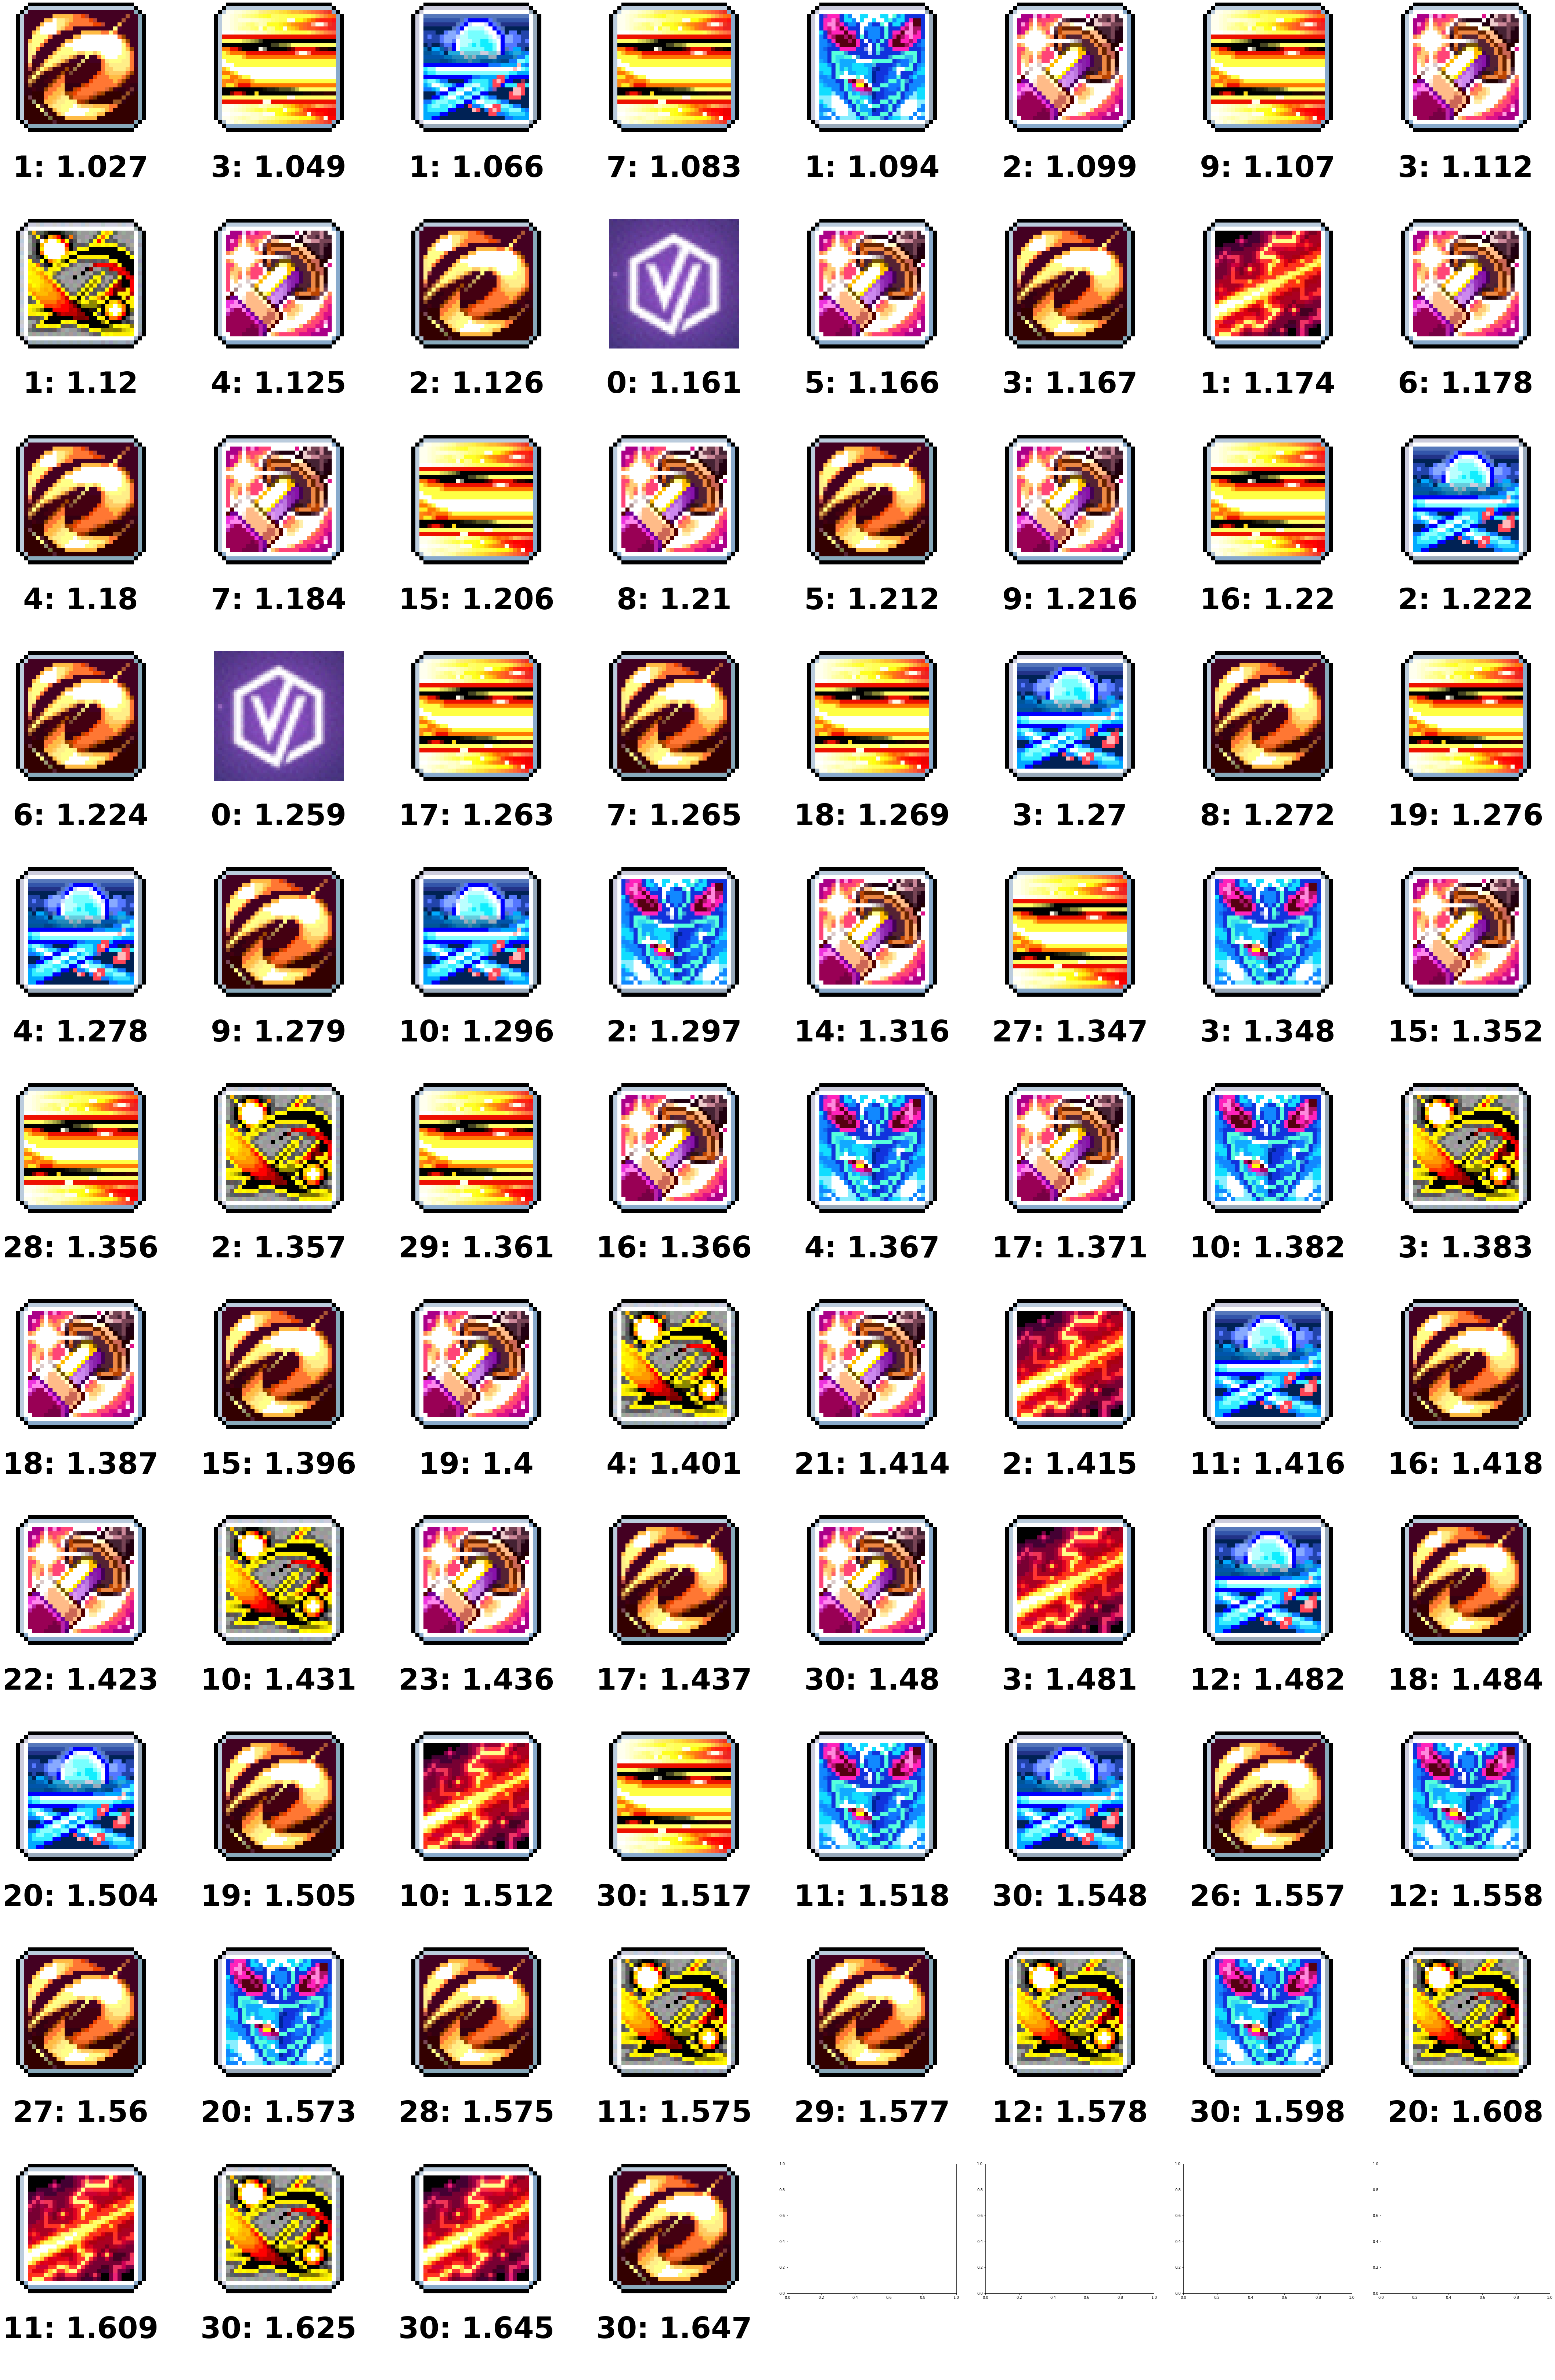

In [203]:
#@title Graphic Generation. Toggle `show_fd` on to show cumulative FD gained at each upgrade
show_fd  = True #@param {allow-input: true, type:"boolean"}

import matplotlib.pyplot as plt
import numpy as np
import urllib
import PIL

# Define the skill names and their corresponding images
# skill_images = {
#     "rbf":    "icons/rbf.webp",
#     "zankou": "icons/zankou.webp",
#     "jinqd":  "icons/jinqd.webp",
#     "slice":  "icons/slice.webp",
#     "jamal":  "icons/jamal.webp",
#     "pb":     "icons/pb.webp",
# }

skill_images = {
    "rbf":    np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/8/85/Skill_HEXA_Rai_Blade_Flash.png/revision/latest?cb=20231116082015"))),
    "zankou": np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/c/c2/Skill_Battoujutsu_Zankou.png/revision/latest?cb=20161204065739"))),
    "jinqd":  np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/4/4e/Skill_Jin_Quick_Draw.png/revision/latest?cb=20231116082013"))),
    "slice":  np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/5/50/Skill_Instant_Slice.png/revision/latest?cb=20201116065820"))),
    "jamal":  np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/d/df/Skill_Battoujutsu_Ultimate_Will.png/revision/latest?cb=20181115065212"))),
    "pb":     np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/5/5f/Skill_Iaijutsu_Phantom_Blade.png/revision/latest?cb=20170609033517"))),
    "hexa":   np.array(PIL.Image.open(urllib.request.urlopen("https://github.com/badinkajink/hayato_6th/blob/main/icons/hexa_icon.png?raw=true"))),
    "shin":   np.array(PIL.Image.open(urllib.request.urlopen("https://static.wikia.nocookie.net/maplestory/images/b/b7/Skill_Shinsoku.png/revision/latest?cb=20151102042946")))
}

# Function to plot the skill upgrades
def plot_skill_upgrades(skill_order):
    # x_axis = int(np.ceil(len(skill_order)/6.0))
    ncols = 8
    nrows = int(np.ceil(len(skill_order)/ncols))
    # x_axis = int(np.ceil(len(skill_order) % num_rows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(60, 90))
    axes = axes.flatten()

    for i, (skill_name, new_level, cumu_fd, prev_level) in enumerate(skill_order):
        # Load skill image
        # image_path = skill_images.get(skill_name)
        img = skill_images.get(skill_name)
        # img = plt.imread(image_path)

        # Plot the skill image
        axes[i].imshow(img)
        axes[i].axis("off")

        # Add text below the skill image
        text = f"{new_level}\n"
        if show_fd:
          text = f"{new_level}: {cumu_fd}\n"
        axes[i].text(0.5, -0.6, text, size=80, weight="bold", ha="center", transform=axes[i].transAxes)

    plt.tight_layout()
    plt.show()

# Plot the skill upgrades
plot_skill_upgrades(trimmed_upgrade_order)


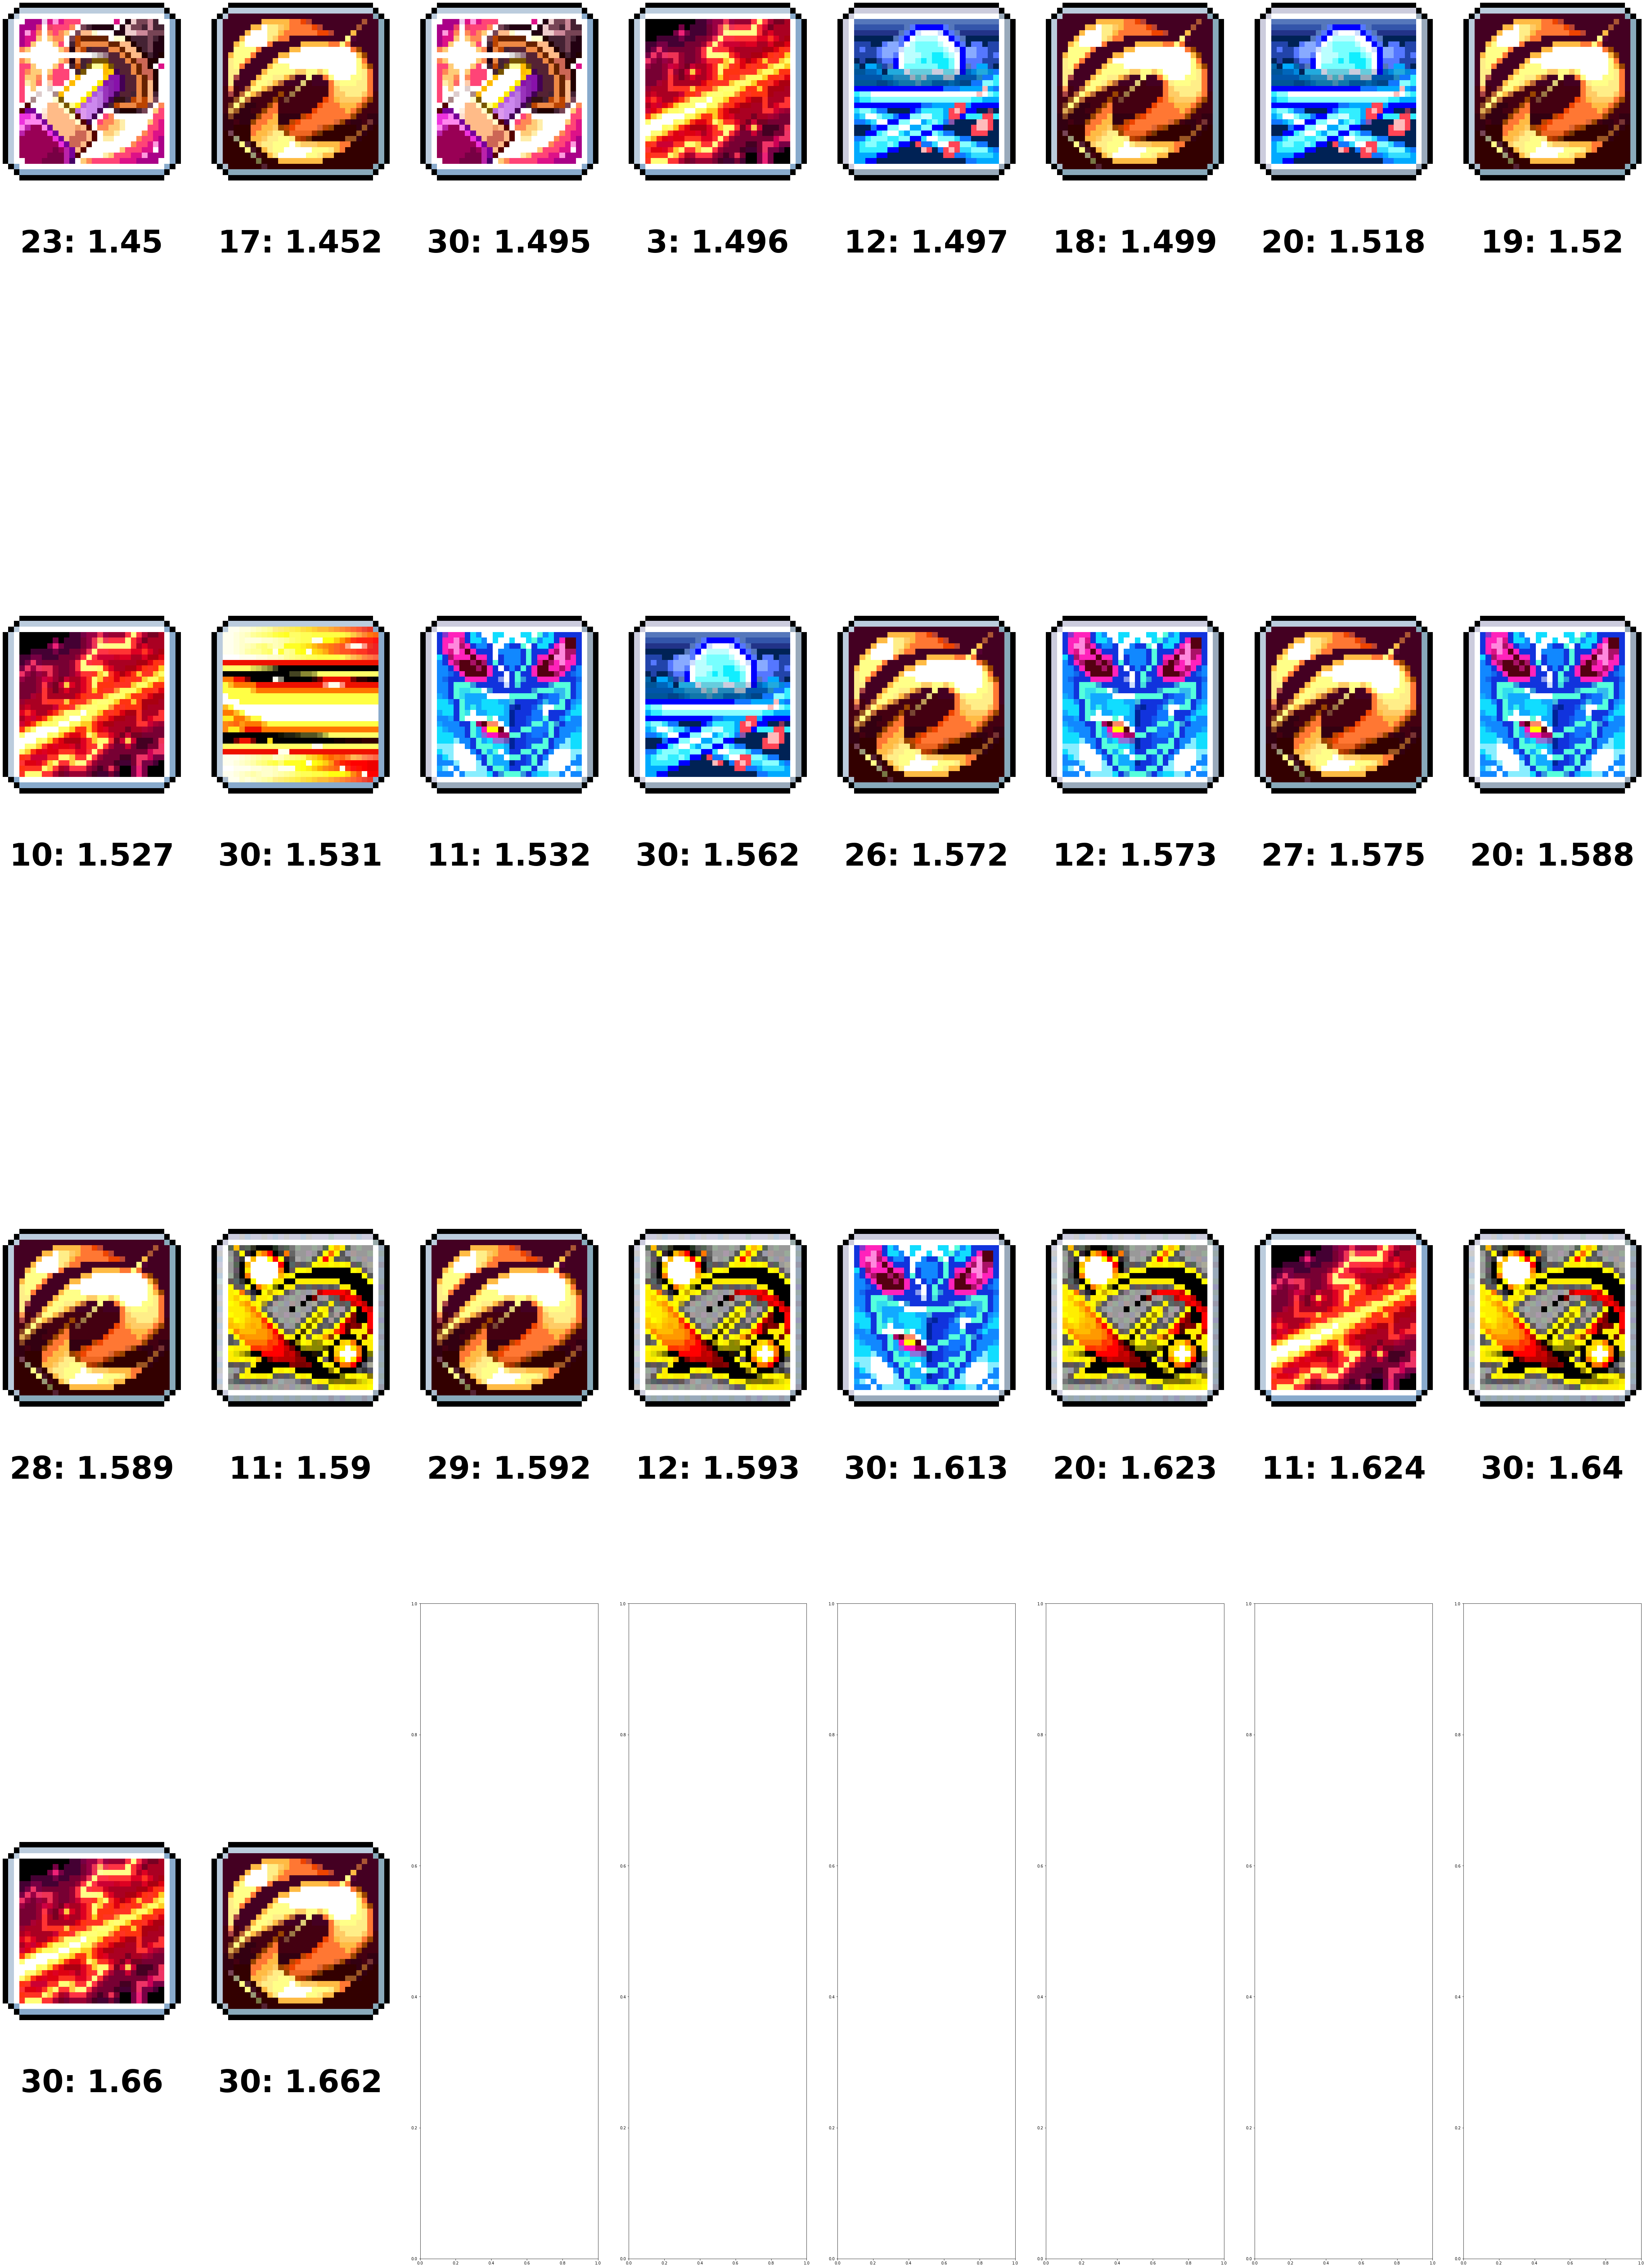

In [204]:
plot_skill_upgrades(curr_trimmed_upgrade_order)

rounding error: -0.015000


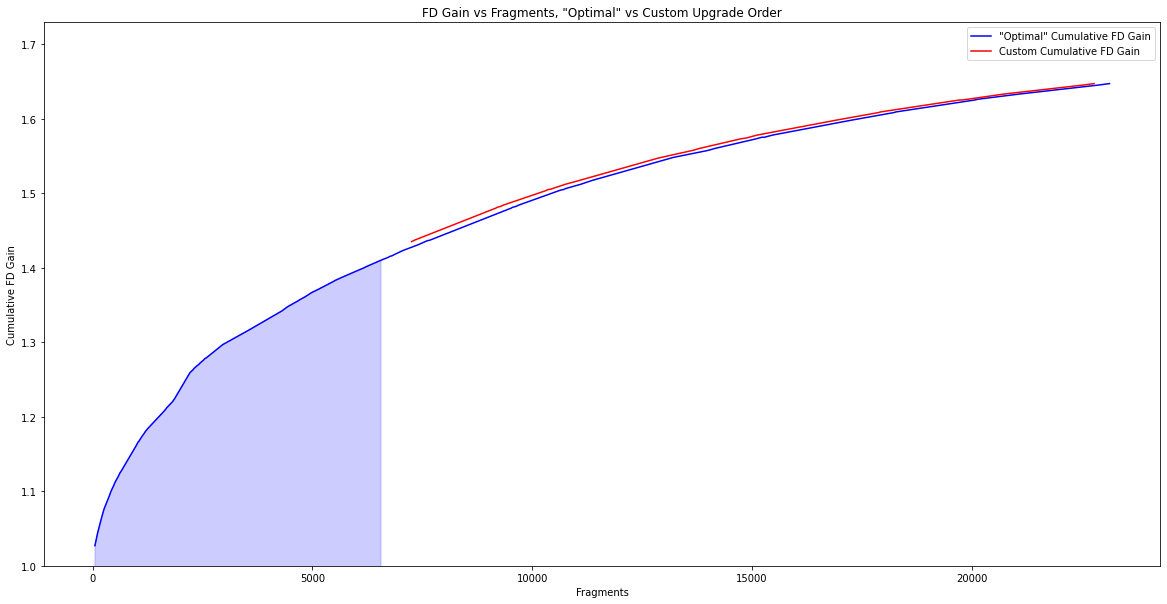

In [205]:
#@title FD vs Frags
# plot the cumulative FD gain (y-AXIS) vs cumulative fragment cost (x-axis) of upgrade order
max_fragments = 22184
def get_cumuluative_costs(upgrade_order):
    # create array of fragment cost of each upgrade in order
    costs = [cost_fn(entry[0], entry[3], entry[1]) for entry in upgrade_order]
    # each entry is the sum of the previous entry and the current entry
    cumulative_costs = np.cumsum(costs)
    return cumulative_costs

def plot_progression(upgrade_order, curr_upgrade_order, skill_dict):
    fig, ax = plt.subplots(figsize=(20, 10))
    # Plot zero progression FD vs Frags
    x = get_cumuluative_costs(upgrade_order)
    y = [entry[2] for entry in upgrade_order]
    ax.plot(x, y, label='"Optimal" Cumulative FD Gain', color="blue")
    ax.set_ylabel('Cumulative FD Gain')
    ax.set_xlabel("Fragments")
    ax.set_title('FD Gain vs Fragments, "Optimal" vs Custom Upgrade Order')

    # Shade in current progression
    total_fragments = 0
    total_fd = 0
    for skill_name, level in skill_dict.items():
        start_level = 0 if not skill_name == "jinqd" else 1
        total_fragments += cost_fn(skill_name, start_level, level)
        total_fd += fd_gain(skill_name, start_level, level)[0]
    ax.fill_between(x, y, where=x<=total_fragments, alpha=0.2, color="blue")

    # Plot remaining curve for current HEXA progression
    x2 = total_fragments + get_cumuluative_costs(curr_upgrade_order)
    x2 += cost_fn("hexa", 0, 1) if YES_I_MAXED_HEXA_STAT else 0
    y2 = np.array([entry[2] for entry in curr_upgrade_order])
    rounding_error = (y[-1] - y2[-1]) # oops, lol
    print(f"rounding error: {rounding_error:>4f}")
    y2 = y2 + rounding_error
    ax.plot(x2, y2, label="Custom Cumulative FD Gain", color="red")
    ax.legend()
    ax.set_ylim(1.0, ax.get_ylim()[1])
    plt.show()


plot_progression(init_upgrade_order, curr_upgrade_order, skills)

    

### Changelog

- 07/12/24: Add MSEA release of Shinsoku VI (2270 --> 2570 max damage, 1475 --> 1584 lv1 damage), comment out unused blocks (ENERGY_FRAG_RATIO, various preliminary BA props), also everything runs now...
- 06/10/24: Add option for second mastery (shinsoku), plot to view FD vs Frags progression, HEXA stat built into upgrade order, ability to back calculate BA proportions, correct FD calculations for computing order with progressed HEXA, change `ENERGY_FRAG_RATIO` to 100 to 0 (i.e. remove `ENERGY_FRAG_RATIO`), TODO: address rounding errors? are they even rounding errors?
- 11/30/23: Change `ENERGY_FRAG_RATIO` to 50 from 100
- 12/03/23: Change `(2,28)` --> `(1,28)` in MASTERY_COST (no ramifications)
- 12/04/23: Add Cumulative FD Gained metric to order output and add some prelim Hexa Stat calculations
- 12/09/23: Add Cumulative FD Gained to image generation. TODO: Improve cost ratio implementation (currently unintuitive) UPDATE: cost ratio is just frags xd
- 12/10/23: Add MoonbunnieDX's burst party play proportions, toggle to set `BA_PROP` to those values, and fix graph order generations for >36 icons.
- 12/11/23: Update and format the run instructions in the header
- 12/21/23: Group input forms near top. TODO: make class-agnostic skill dictionary
- 02/23/24: Update image link for Battoujutsu Ultimate Will, which changed names in the most recent patch